<a href="https://colab.research.google.com/github/robosquiggles/2156_Demos/blob/main/2_156_Fall_24_Demo_2_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.155/6 Optimization Demo
### In this demo we will demonstrate the use of both gradient-based optimization and evolutionary optimization on a linkage design problem. This notebook also serves as an introduction to the Challenge Problem 1, which will tackle a more complex linkage design problem.

*Created by L. Regenwetter and A.H. Nobari in Sep. 2024*


In [ ]:
%%capture
#We start by installing libraries and importing some supporting code from a Github repository which will be used for linkage optimization
!pip install pymoo==0.6 svgpath2mpl
!git clone https://github.com/ahnobari/MOOCP.git

## Optimization Using Genetic Algorithms and Gradient Based Algorithms

In this notebook, we will demonstrate how optimization using a genetic algorithm (GA) can be easily done using Python. Then we will play around with some of the parameters of the GA to see how this affects the performance and behavior of the GA. We will also look at gradient-based optimization using the `scipy.optimize` library.

### Import Necessary Python Modules

First, we will import some of the libraries which will help us with implementing a simple GA using Python. For this demo, the most relevant modules are:

<ol>
    <li><b>Numpy</b>: A linear algebra and high dimensional array library which allows us to work with high dimensional arrays and matrices and perform linear algebra operations.</li>
    <li><b>Matplotlib</b>: A library used for visualizations</li>
    <li><b>Pymoo</b>: A powerful optimization library that includes implementations of different kinds of optimization algorithms that can be used for optimization in Python.</li>    
</ol>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymoo
import svgpath2mpl
# Utiliies for working with linkages (DeCoDE Lab)
from MOOCP.linkage_utils import *

# Other modules
import json
from IPython.display import HTML
import matplotlib.animation as animation

### Problem Statement
In this example, we will implement GA for the linkage synthesis problem discussed before. Here we will start with a mechanism similar to the image below:

<img src="https://i.ibb.co/9qvDWGJ/simple.png" alt="4-bar with with extended linkage" border="0">

In this problem, we intend to find the positions of the nodes such that the target node (highlighted in orange above) will trace a path with the shape and size of a specific target curve. The shape of the target curve is as displayed below:

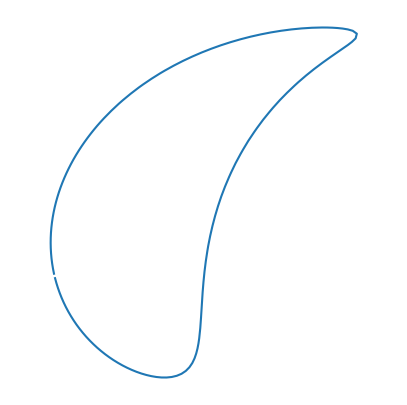

In [ ]:
#We will load up a target curve from a collection stored on github and scale it slightly
target_curve = np.load('./MOOCP/TestData/random_mechanisms.npy')[150] * 0.15

plt.figure(figsize=(5,5))
plt.plot(target_curve[:,0], target_curve[:,1])
plt.axis('equal')
plt.axis('off');

### Setting Up The Problem
Now we will start to set up the problem within python.

#### Representing The Mechanism
A linkage mechanisms structure can be represented using a matrix of connectivity (C), similar to the adjacency matrix in graphs. The connectivity matrix for mechanisms with $N$ nodes is a symmetric $N\times N$ matrix with each row and column representing each node and its connections to other nodes. Take the example below:

<img src="https://transportgeography.org/wp-content/uploads/simple_connectivity_matrix2.png">

For Node A, we use the first row/column of the matrix, and we see that A is connected to B (which is represented by the second row/column). To represent this connection in the connectivity matrix, we will set the value of the $(1,2)$ and $(2,1)$ elements of the matrix to be 1. Similarly any time any nodes $i$ and $j$ are connected we set the value of the $(i,j)$ and $(j,i)$ elements to be 1 and 0 if the nodes are not connected.

Now looking back at the mechanism we want to optimize, we can create its connectivity matrix. First, decide the index of each node, so we know what order the adjacency matrix will be defined with:

<img src="https://i.ibb.co/qsPC0gC/2021-09-13-0hl-Kleki.png" alt="Numbered Mechanism" border="0">


In [ ]:
# Manualy define the connectivity matrix
C = np.array([[0,0,1,0,0],
              [0,0,0,1,0],
              [1,0,0,1,1],
              [0,1,1,0,1],
              [0,0,1,1,0]])

To define the mechanism, we must also know which nodes are fixed (or ground nodes). To do this, we will store a list of node indices (The number of nodes as represented in the adjacency matrix C) that are fixed. Note that in Python, indexes of arrays and lists start from 0:

In [ ]:
fixed_nodes = np.array([0,1])

The last thing to define a mechanism is to store the initial positions of the nodes. To do this, we will use an $N \times 2$ matrix. We store the position of the $i$-th node in the $i$-th row of the initial position matrix (with the $x,y$ coordinates going into the $(i,0)$ and $(i,1)$ elements of the matrix respectively). Note that in our representation, we will position nodes within a 1x1 box, so the maximum position of the nodes should not exceed 1.0. We also set up a flattened version of x0, since many optimizers require a 1D design vector.

In [ ]:
x0 = np.array([[0.3,0.2],
               [0.9,0.2],
               [0.3,0.3],
               [0.9,0.4],
               [0.75,0.5]])

Finally, we must define which linkage is driven by a motor. We represent this as a 1-D array of size 2, which has the start and end node numbers of the driven linkage.

In [ ]:
motor = np.array([0,2])

Now let's see what our mechanism looks like. To do this use the draw_mechanism(C,x0,fixed_nodes,motor) function we have defined:

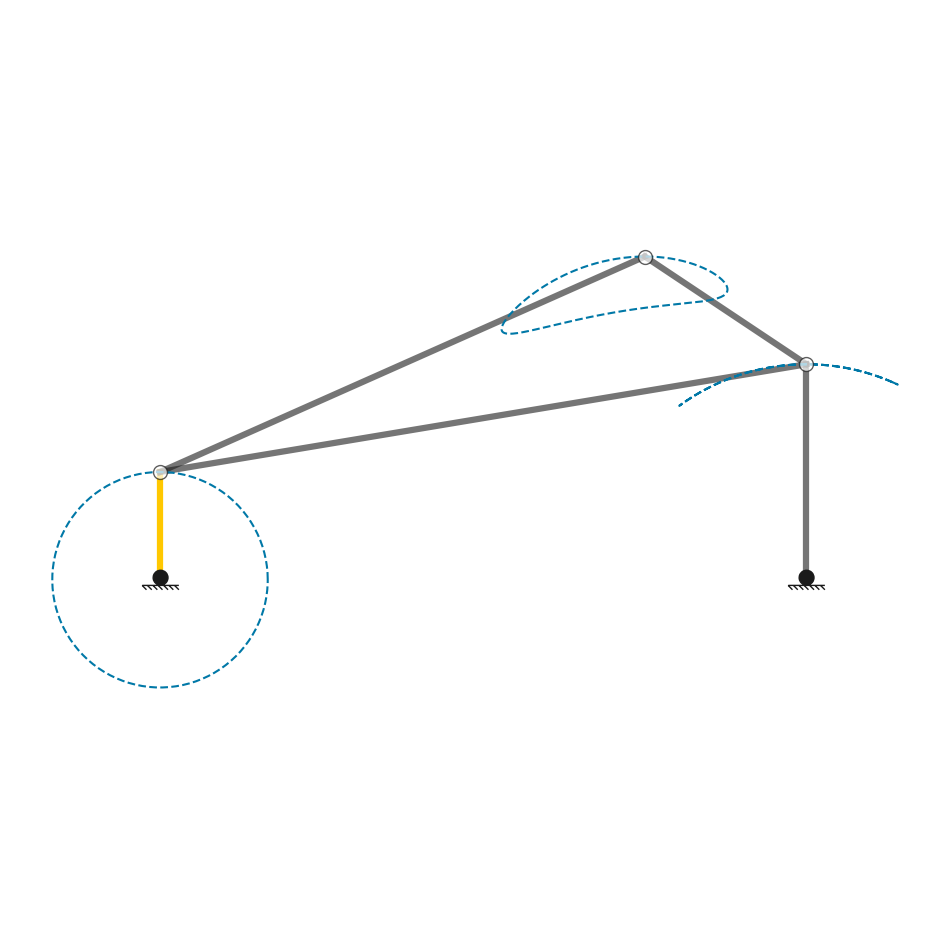

In [ ]:
draw_mechanism(C,x0,fixed_nodes,motor)

## Gradient Based Optimization
Now we will first look at how we can use gradient-based optimization to solve this problem. We will use the `scipy.optimize` library to do this. We will be specifically using the BFGS algorithm.

We have prepared a function, `optimization_functions` which creates the necassry function for optimization. It takes in a connectivity matrix, node coorinates, a list of ground nodes, and a target curve as input. It simulates the motion of the mechanism, and differentiably claculates distance to the target curve and the total sum of link lengths for the mechanism. Specifically, it returns six items:

1. v: Whether the provided mechanism is valid. There are many ways a mechanism can be invalid. It can be over- or under-constrainted, meaning that the mechanism either cannot move, or its movement is indeterminate, respectively. In addition, even if it is correctly-constrained, the mechanism can lock before it is able to complete a full rotation. We consider such locking mechanisms invalid as well.
2. obj_fn: A function which takes a set of node coordinates and returns the distance to the target curve (objective function).
3. obj_fn_grad: A function which takes a set of node coordinates and returns the gradient of the distance to the target curve with respect to the node coordinates.
4. mat_fn: A function which takes a set of node coordinates and returns the total length of all links in the mechanism (material use).
5. mat_fn_grad: A function which takes a set of node coordinates and returns the gradient of the total length of all links in the mechanism with respect to the node coordinates.
3. aligned_curve: The transformed target curve that is aligned with the mechanism output.

In [ ]:
v, obj_fn, obj_fn_grad, mat_fn, mat_fn_grad, aligned_curve = optimization_functions(C,x0,fixed_nodes,target_curve, motor)

Now let's display the aligned target curve and the mechanism:

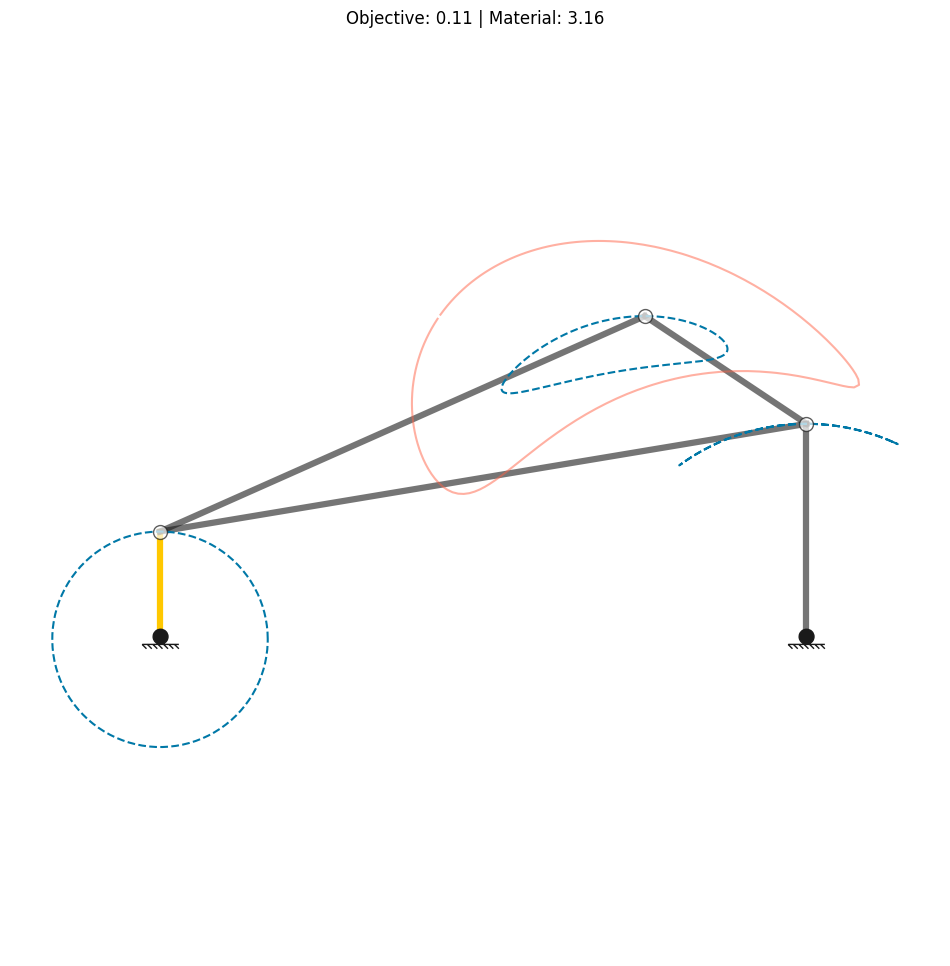

In [ ]:
obj, obj_grad = obj_fn(x0), obj_fn_grad(x0)
mat, mat_grad = mat_fn(x0), mat_fn_grad(x0)

draw_mechanism(C, x0, fixed_nodes, motor)
plt.plot(aligned_curve[:,0], aligned_curve[:,1], 'tomato', alpha=0.5)
plt.title(f'Objective: {obj:.2f} | Material: {mat:.2f}');

### Optimizing using scipy

Let's try some optimizers from the scipy minimize function. First, we try BFGS

In [ ]:
from scipy.optimize import minimize
#create a callback function in order to save all the node position values over the course of optimization
x_history = []
CD_history = []
def callback(x):
    x_history.append(x)
    CD_history.append(obj_fn(x))
res = minimize(obj_fn,x0.reshape(-1),jac=obj_fn_grad,method='BFGS', callback = callback)

Let's create a function that generates animations to show the convergence of the node locations:

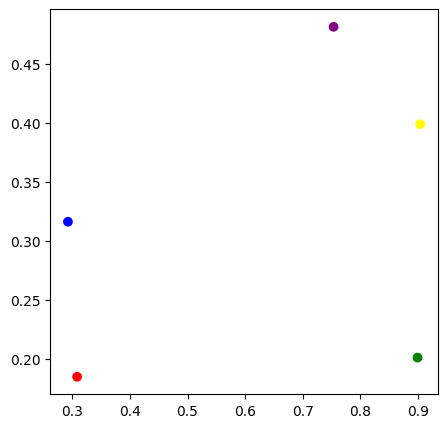

In [ ]:
%matplotlib inline
def x_convergenceplot(history, frames):
    #Plot one frame of the animation
    convergence = np.stack(history)
    fig, ax = plt.subplots(figsize=(5,5));
    plt.axis('equal')
    plt.xlim([0,1])
    plt.ylim([0,1])
    def animate(i):
        plt.clf()
        for j in range(i): # Loop over previous steps and make a semi-transparant point for each
            c = convergence[j,:]
            inits = np.reshape(c,[5,2])
            plt.scatter(inits[:,0],inits[:,1], c = ['red', 'green', 'blue', 'yellow', 'purple'], alpha=0.2)
        c = convergence[i,:]
        inits = np.reshape(c,[5,2])
        plt.scatter(inits[:,0],inits[:,1], c = ['red', 'green', 'blue', 'yellow', 'purple']) #Dark point at current step
    return animation.FuncAnimation(fig, animate, frames=frames, interval=200)

#Generate an animation
ani = x_convergenceplot(x_history, range(len(x_history)))
HTML(ani.to_html5_video())


Let's also plot the convergence of the Chamfer Distance:

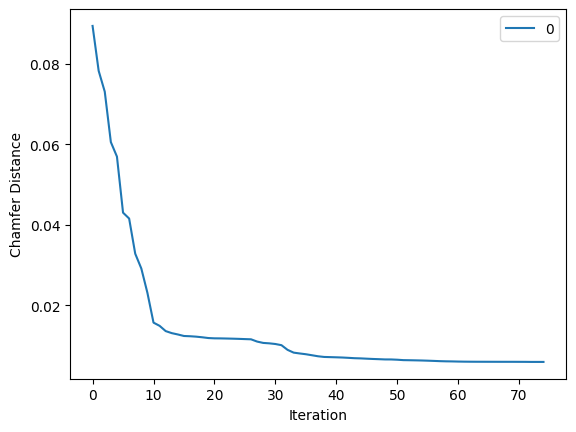

In [ ]:
def plot_CD_convergence(CD_history,n=0):
    plt.plot(CD_history,label=n)
    plt.ylabel("Chamfer Distance")
    plt.xlabel("Iteration")
    plt.legend()
plot_CD_convergence(CD_history)

We make a function to compare our generated curve to our target curve.

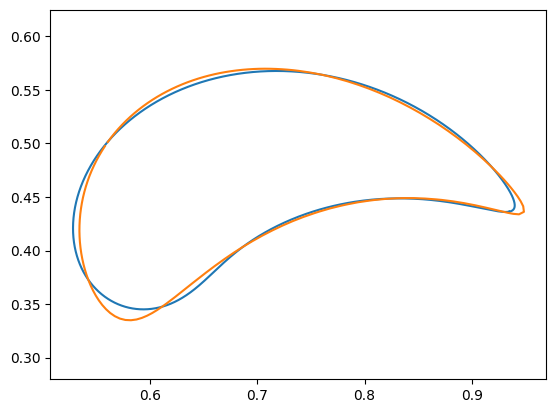

In [ ]:
from MOOCP.linkage_utils import preprocess_curves
def comparecurves(x, aligned_curve):
    sol = solve_mechanism(C,x.reshape(x0.shape),fixed_nodes,motor)[1][0,-1,:]
    plt.plot(sol[:,0],sol[:,1])
    plt.plot(aligned_curve[:,0],aligned_curve[:,1])
    plt.axis('equal')
comparecurves(res.x, aligned_curve)

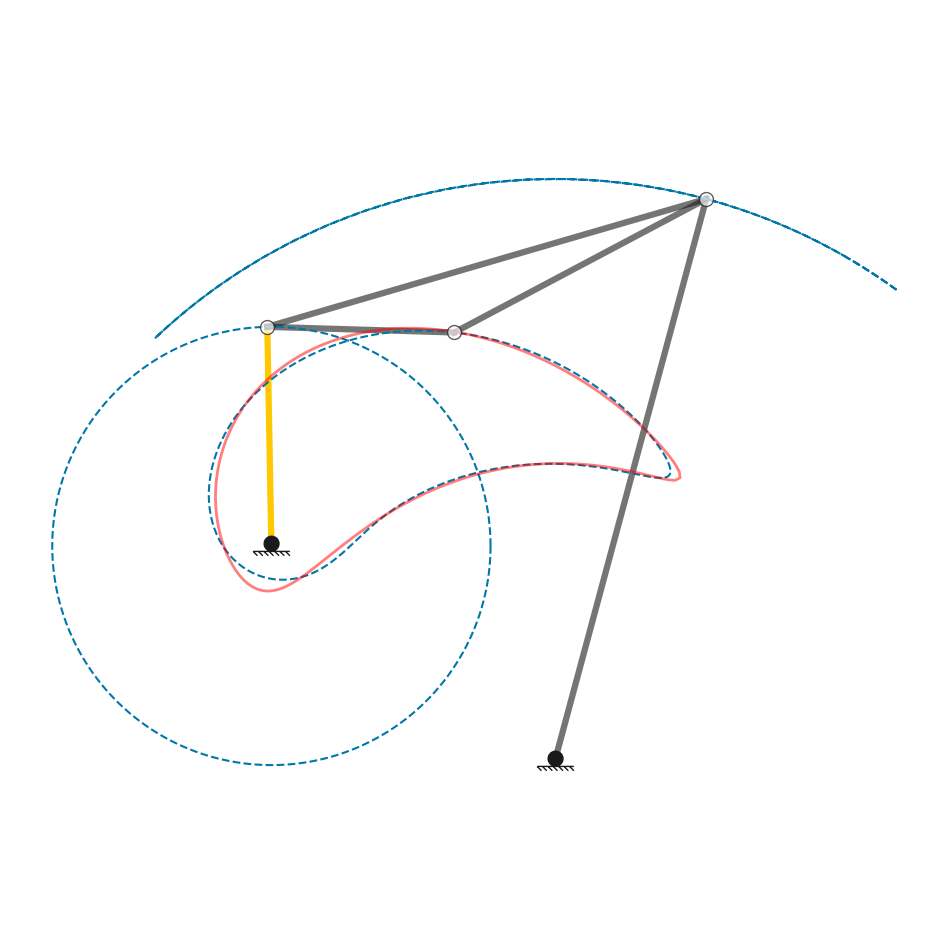

In [ ]:
draw_mechanism(C,res.x.reshape(5,2),fixed_nodes,motor)
plt.plot(aligned_curve[:,0],aligned_curve[:,1], color='red', linewidth=2, alpha=0.5);

Let's try another one where our starting configuration is different! We redifine our starting node positions (keeping the general configuration of the linkage the same). Next, we visualize the starting configuration of the linkage.

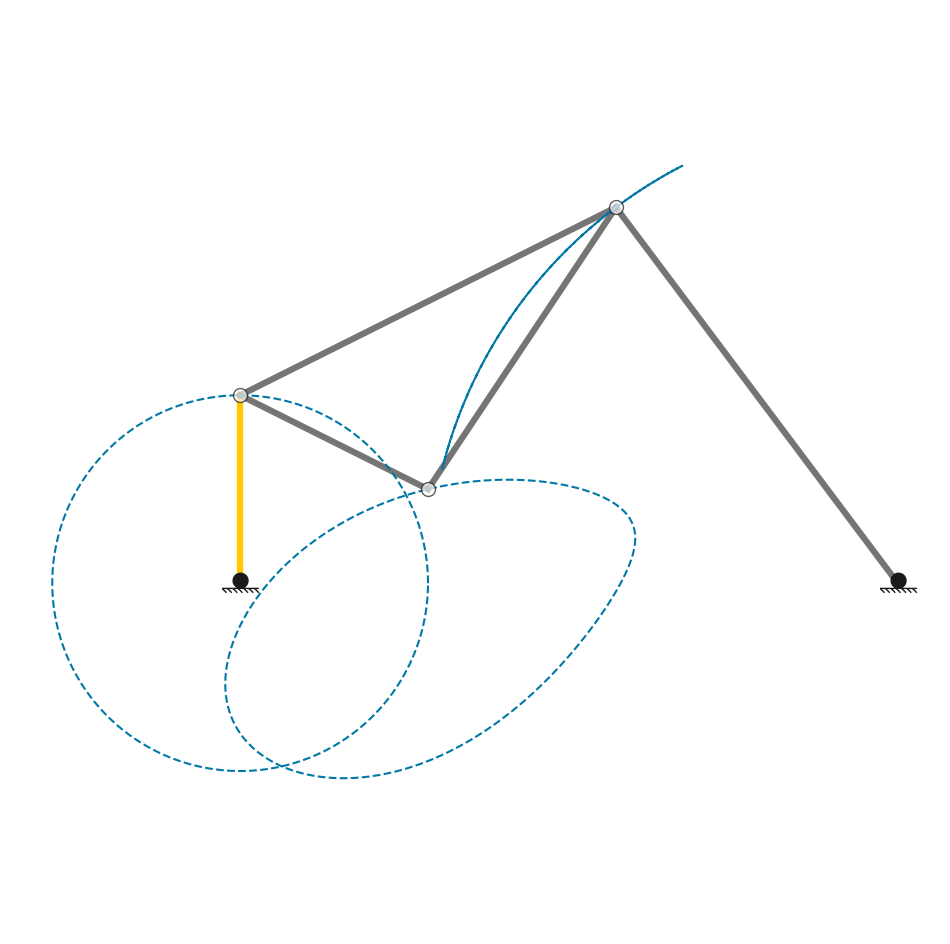

In [ ]:
C = np.array([[0,0,1,0,0],
              [0,0,0,1,0],
              [1,0,0,1,1],
              [0,1,1,0,1],
              [0,0,1,1,0]])
fixed_nodes = np.array([0,1])
x0 = np.array([[0.8,1.0],
               [1.5,1.0],
               [0.8,1.2],
               [1.2,1.4],
               [1.0,1.1]])
motor = np.array([0,2])
draw_mechanism(C,x0.reshape(5,2),fixed_nodes,motor)

Next, we optimize starting from this new starting configuration.This time, we should see that the optimizer finds a different minimum. Gradient descent does is not guaranteed to (and rarely does) find the global optimum!

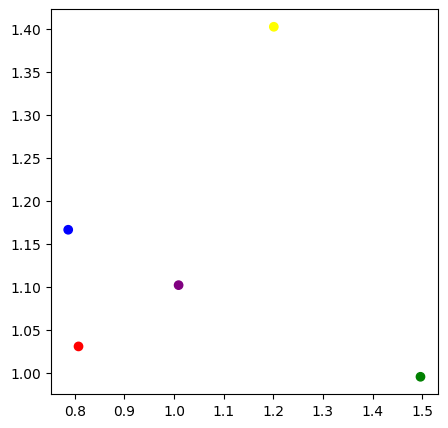

In [ ]:
valid, obj_fn, obj_fn_grad, mat_fn, mat_fn_grad, aligned_curve = optimization_functions(C,x0,fixed_nodes,target_curve, motor)

x_history = []
CD_history = []
def callback(x):
    x_history.append(x)
    CD_history.append(obj_fn(x))
res = minimize(obj_fn,x0.reshape(-1),jac=obj_fn_grad,method='BFGS', callback = callback)

ani = x_convergenceplot(x_history, range(len(x_history)))
HTML(ani.to_html5_video())

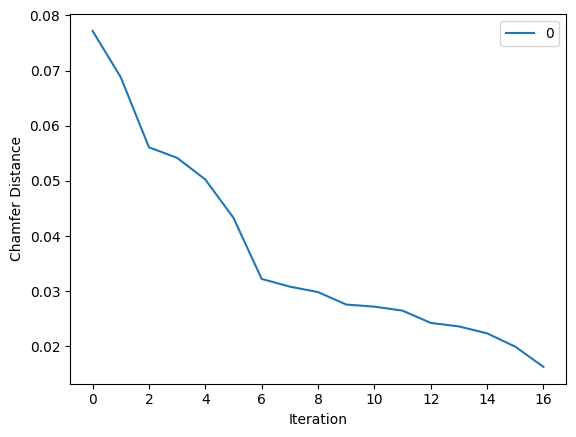

In [ ]:
plot_CD_convergence(CD_history)

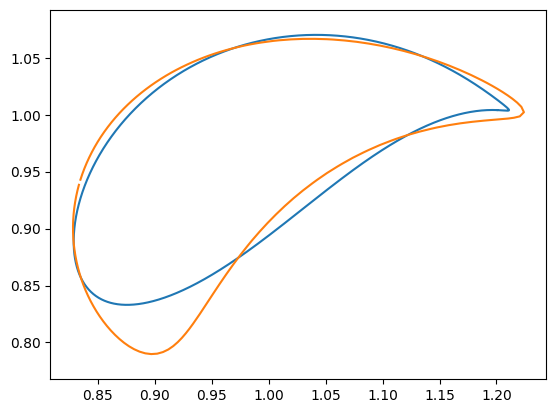

In [ ]:
comparecurves(res.x, aligned_curve)

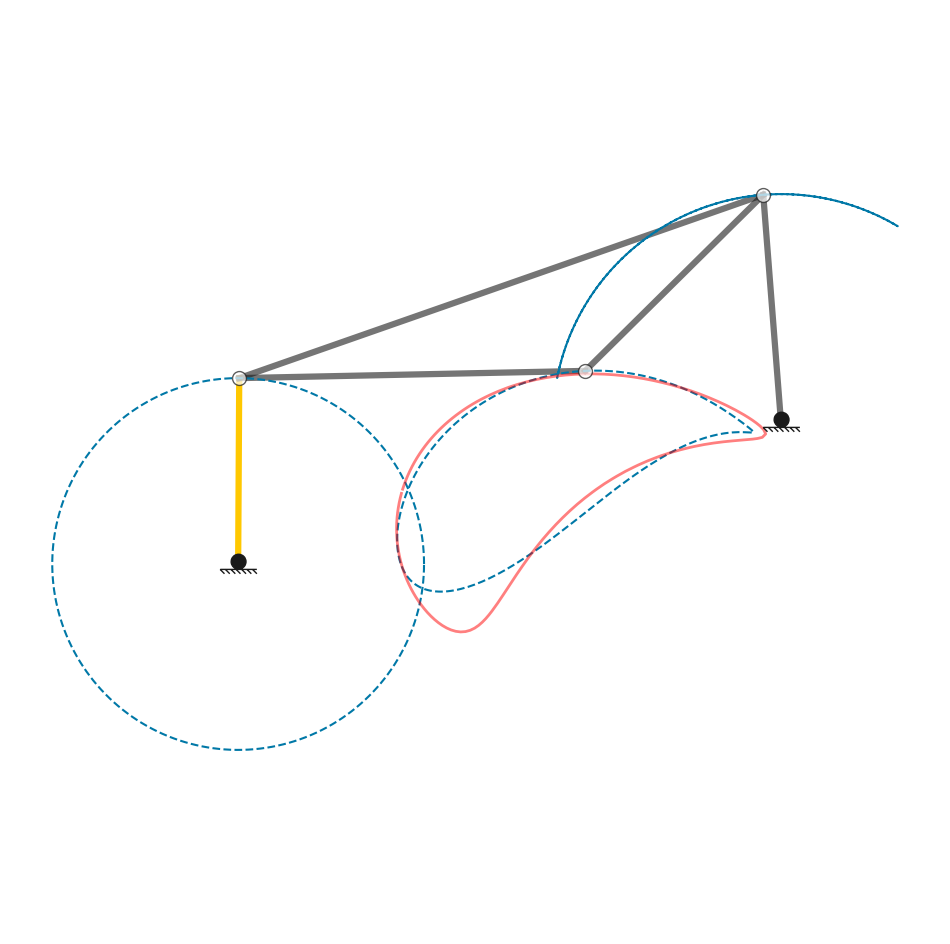

In [ ]:
draw_mechanism(C,res.x.reshape(5,2),fixed_nodes,motor)
plt.plot(aligned_curve[:,0],aligned_curve[:,1], color='red', linewidth=2, alpha=0.5);

### Optimization using Genetic Algorithm
When optimizing using a Genetic Algorithm, gradient information is not utilized. We have implemented a simple function that calculates the validity, chamfer distance, and material use, without calculating gradients. This function is more efficient than the gradient-based function call.



We will use the pymoo implementation of the NSGA-II algorithm. To use pymoo we must first define the problem within pymoo. There are several things to note about this problem. First, we have to set the number of parameters which in this case are the $x,y$ positions of the 5 nodes (2x5=10 parameters). The other part of the problem is the number of objectives. For us, since we are looking at the similarity of the shapes in the output and the target we only have one target. The last thing is to set the lower and upper bound for the parameters, which will be 0.0 and 2.0 respectively.

In [ ]:
from pymoo.core.problem import ElementwiseProblem
class mechanism_optimization(ElementwiseProblem):

    # When intializing get the mechanism structure which is being optimized
    #(not the initial positions as we are trying to find those)
    def __init__(self,C,fixed_nodes,motor,target_point_cloud):

        # set the problem paramters(n_var = number of parameters(number of nodes * 2),
        # n_obj=number of objectives, xl=lower bound for the parameters, xu=upper bound for the paramters)
        super().__init__(n_var = C.shape[0] * 2, n_obj=1, xl=0.0, xu=2.0, elementwise_evaluation=True)

        # Store mechanism information for later
        self.C = C
        self.fixed_nodes = fixed_nodes
        self.motor = motor
        self.N = C.shape[0]

        # Store the target curve point cloud
        self.tpc = target_point_cloud


    def _evaluate(self, x, out, *args, **kwargs):
        x0 = np.array(x.reshape([self.N,2]))  #reshape the flattened vector that comes in into 2D array

        # Simulate
        valid, CD, mat, _ = evaluate_mechanism(self.C,x0,self.fixed_nodes, self.motor, self.tpc, idx=None,device='cpu',timesteps=2000)
        # valid, CD, mat, CD_grad,mat_grad,g_c = functions_and_gradients(C,x0,fixed_nodes, target_curve, motor)

        # check to see if the mechanism is valid
        if not valid:
            # if mechanism is invalid set the objective to infinity
            out["F"] = np.Inf
        else:
            # Send the chamfer distance to pymoo as objective
            out["F"] = CD

### NSGA-II

Now that we have setup our problem we will now setup NSGA-II for our problem using pymoo:

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation

# Setup an instance of our problem
problem = mechanism_optimization(C,fixed_nodes,motor,target_curve)

# Setup the algorithm
algorithm = NSGA2(pop_size=30,
                sampling=FloatRandomSampling(),
                crossover=SBX(prob=1.0, eta=3.0),
                mutation=PolynomialMutation(eta=3.0, prob=0.05),
                eliminate_duplicates=True)

Now we will set the algorithm to minimize the objective for 50 generations. WARNING: Scipy's <code>minimize</code> function will be overwritten by pymoo's. If you go back to scipy, make sure to reimport!

In [ ]:
from pymoo.optimize import minimize
results = minimize(problem,
                   algorithm,
                   ('n_gen', 50),
                   verbose=True,
                   save_history=True,
                   seed=3,
                   display=best())

Now lets visualize the evolution:

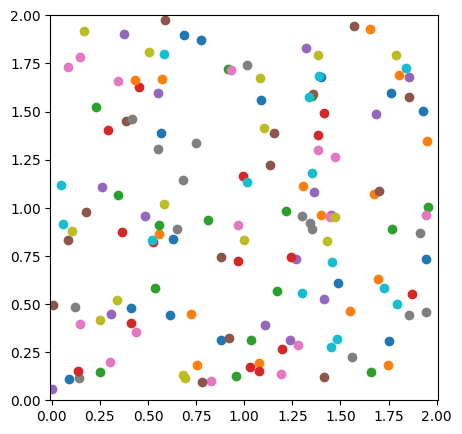

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))
def animate(i):
    plt.clf()
    population = results.history[i].pop.get("X")
    for m in population:
        inits = np.reshape(m,[5,2])
        plt.scatter(inits[:,0],inits[:,1])
    plt.axis('equal')
    plt.xlim([0,2])
    plt.ylim([0,2])


ani = animation.FuncAnimation(fig, animate, frames=50)

HTML(ani.to_html5_video())

Now lets see the best solution(s) the algorithm came up with:

In [ ]:
if results.X.ndim >1:
    best_x0 = results.X[0]
else:
    best_x0 = results.X

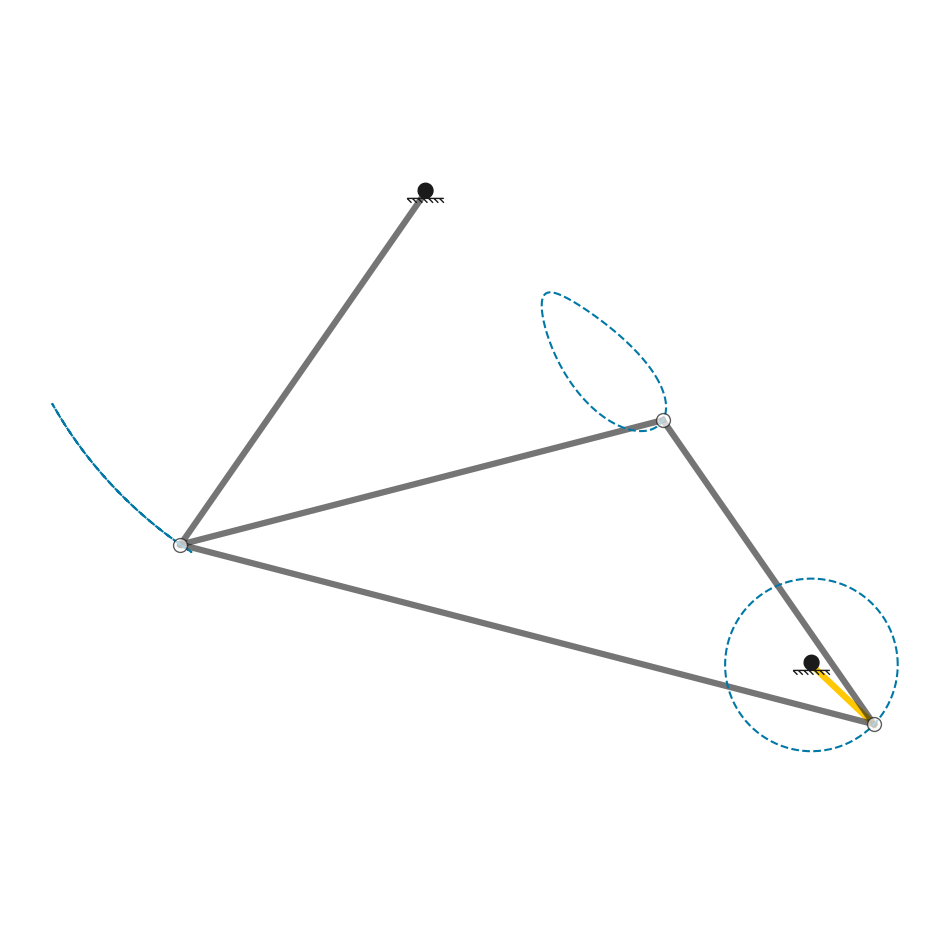

In [ ]:
# Step 1: Reshape
best_x0 = np.reshape(best_x0,[5,2])

# Step 2: Draw
draw_mechanism(C,best_x0,fixed_nodes,motor)

Now let's overlay the curves to see how close we got

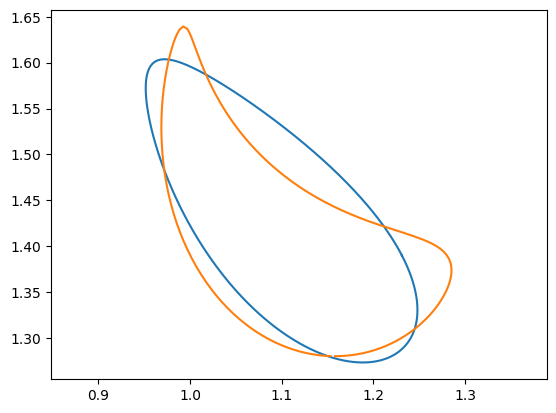

In [ ]:
_, _, _, _, _, aligned_curve = optimization_functions(C,best_x0,fixed_nodes,target_curve,motor)
comparecurves(best_x0, aligned_curve)

The results may not be all that strong. Let us play around with the algorithm a little to see if we can get better results. Let's start by setting a higher probability for mutation:

In [ ]:
# Setup and instance of our problem
problem = mechanism_optimization(C,fixed_nodes,motor,target_curve)

# Setup Algorithm
algorithm = NSGA2(pop_size=30,
                                   sampling=FloatRandomSampling(),
                                   crossover=SBX(prob=1.0, eta=3.0),
                                   mutation=PolynomialMutation(eta=3.0, prob=0.2),
                                   eliminate_duplicates=True)

In [ ]:
results = minimize(problem,
                   algorithm,
                   ('n_gen', 50),
                   verbose=True,
                   save_history=True,
                   seed=3,
                   display=best())

Now lets visualize the evolution:

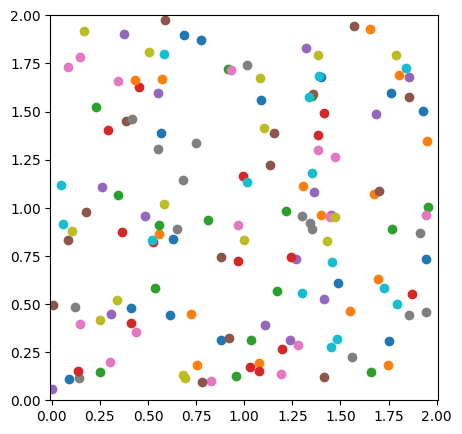

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))
def animate(i):
    plt.clf()
    population = results.history[i].pop.get("X")
    for m in population:
        inits = np.reshape(m,[5,2])
        plt.scatter(inits[:,0],inits[:,1])
    plt.axis('equal')
    plt.xlim([0,2])
    plt.ylim([0,2])


ani = animation.FuncAnimation(fig, animate, frames=50)

HTML(ani.to_html5_video())

Now lets see the best solution(s) the algorithm came up with:

In [ ]:
if results.X.ndim >1:
    best_x0 = results.X[0]
else:
    best_x0 = results.X

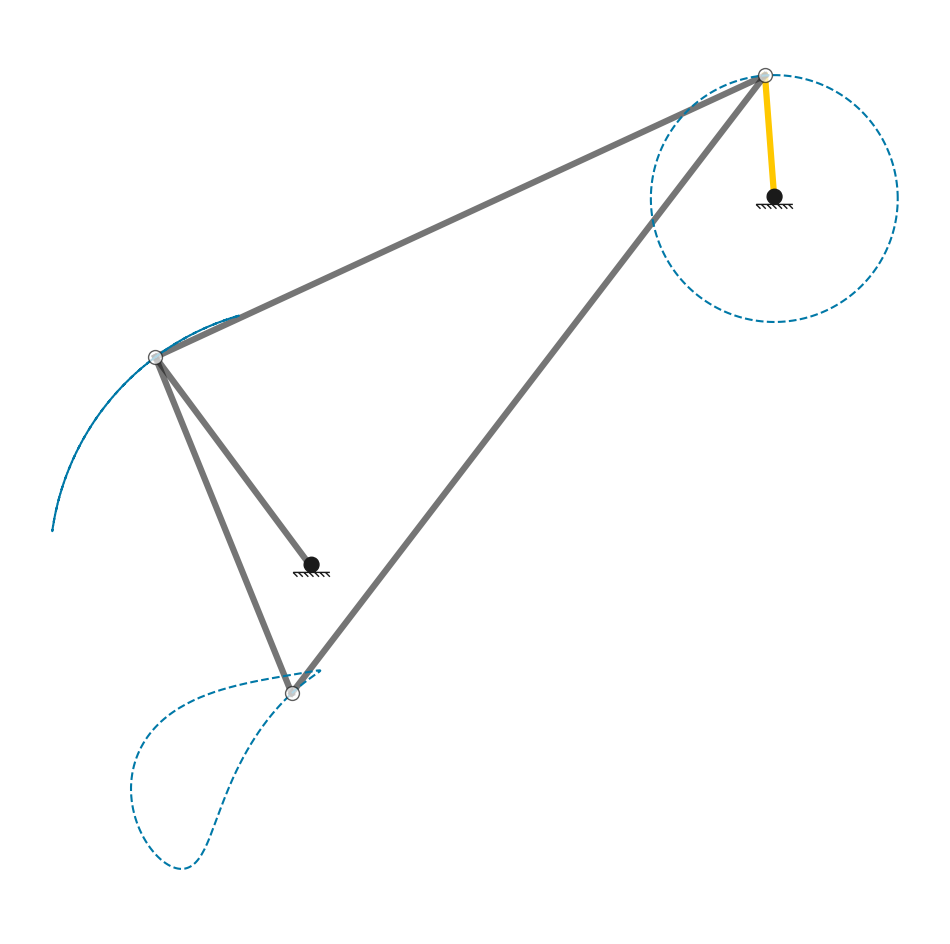

In [ ]:
# Step 1: Reshape
best_x0 = np.reshape(best_x0,[5,2])

# Step 2: Draw
draw_mechanism(C,best_x0,fixed_nodes,motor)

Now lets overlay the curves to see how close we got:

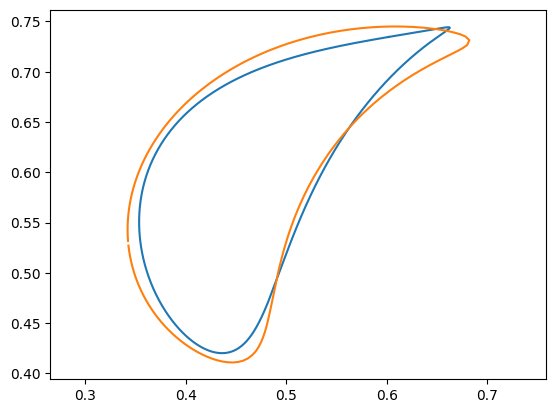

In [ ]:
_, _, _, _, _, aligned_curve = optimization_functions(C,best_x0,fixed_nodes,target_curve,motor)
comparecurves(best_x0, aligned_curve)

### Multi-Objective Problem
Now that we have seen how single objective optimization using NSGA-II can be applied using pymoo let's move on towards multiple objectives. For this example, we will set the second objective to be matching the shape while using the least possible material. The material usage, in this case, will be the sum of the length of the linkages. To get this value you can use the code we have provided. The solver instance has a method called <code>solver.material(x0,C)</code> which will give you this value. Now let us set up our multi-objective problem exactly like we did before:

In [ ]:
class multi_objective_mechanism_optimization(ElementwiseProblem):

    # When intializing get the mechanism structure which is being optimized
    #(not the initial positions as we are trying to find those)
    def __init__(self,C,fixed_nodes,motor,target_point_cloud):

        # set the problem paramters(n_var = number of parameters(number of nodes * 2),
        # n_obj=number of objectives, xl=lower bound for the parameters, xu=upper bound for the paramters)
        super().__init__(n_var = C.shape[0] * 2, n_obj=2, xl=0.0, xu=2.0, elementwise_evaluation=True)

        # Store mechanism information for later
        self.C = C
        self.fixed_nodes = fixed_nodes
        self.motor = motor
        self.N = C.shape[0]

        # Store the target curve point cloud
        self.tpc = target_point_cloud

    def _evaluate(self, x, out, *args, **kwargs):
        x0 = x.reshape([self.N,2])  #reshape the flattened vector that comes in into 2D array

        # Simulate
        valid, CD, mat, _ = evaluate_mechanism(C,x0,fixed_nodes, motor, self.tpc, idx=None,device='cpu',timesteps=2000)
        # valid, CD, mat, CD_grad,mat_grad,g_c = functions_and_gradients(C,x0,fixed_nodes, target_curve, motor)
        # check to see if the mechanism is valid
        if not valid:
            # if mechanism is invalid set the objective to infinity
            out["F"] = np.Inf, np.Inf
        else:
            # Send the chamfer distance to pymoo as objective
            out["F"] = CD, mat

### Multi-Objective NSGA-II

Now lets repeat what we did before, this time for the two objectives.

In [ ]:
# Setup and instance of our problem
problem = multi_objective_mechanism_optimization(C,fixed_nodes,motor,target_curve)

# Setup Algorithm
algorithm = NSGA2(pop_size=30,
                sampling=FloatRandomSampling(),
                crossover=SBX(prob=1.0, eta=3.0),
                mutation=PolynomialMutation(eta=3.0, prob=0.2),
                eliminate_duplicates=True)

In [ ]:
results = minimize(problem,
                   algorithm,
                   ('n_gen', 50),
                   verbose=True,
                   save_history=True,
                   seed=3,
                   display=best())

Now let's visualize the evolution:

[1.69660779 0.629306   0.55858919 0.86163004 1.078893   0.19113363
 1.67382428 1.06946974 1.54993563 0.46167253]
[1.9305867  1.50205461 0.68618773 1.89705529 1.40102356 1.68112217
 0.09099461 0.11128308 1.48547455 0.60937287]
[1.452639   0.96047991 1.68420637 1.48950465 1.32065181 1.82795053
 1.26733113 0.73188117 1.10568915 0.39276115]
[0.22986448 1.52423168 0.34645001 1.06767208 0.25287461 0.14583419
 1.21805489 0.98240626 1.34961987 1.58170837]
[1.38295502 1.30095372 1.44787828 0.95017722 1.19332755 0.13393885
 0.14512428 0.39795205 0.30372199 0.20020869]
[1.19400648 0.26843634 0.45542579 1.62956483 0.52865105 0.82064041
 1.87194435 0.55110493 0.29057992 1.40404026]
[0.74720025 1.33626961 0.67969733 1.14558774 0.65161432 0.8902901
 0.12305786 0.48535084 1.94320521 0.46116841]
[1.1341331  1.22318767 0.0840617  0.83453379 0.00853287 0.49307094
 1.41211237 0.12308143 0.589387   1.97622551]
[1.10159581 1.41629565 0.58180948 1.02165521 1.78589391 1.79258618
 0.25117062 0.41448576 0.10293

[1.69660779 0.629306   0.55858919 0.86163004 1.078893   0.19113363
 1.67382428 1.06946974 1.54993563 0.46167253]
[1.9305867  1.50205461 0.68618773 1.89705529 1.40102356 1.68112217
 0.09099461 0.11128308 1.48547455 0.60937287]
[1.452639   0.96047991 1.68420637 1.48950465 1.32065181 1.82795053
 1.26733113 0.73188117 1.10568915 0.39276115]
[0.22986448 1.52423168 0.34645001 1.06767208 0.25287461 0.14583419
 1.21805489 0.98240626 1.34961987 1.58170837]
[1.38295502 1.30095372 1.44787828 0.95017722 1.19332755 0.13393885
 0.14512428 0.39795205 0.30372199 0.20020869]
[1.19400648 0.26843634 0.45542579 1.62956483 0.52865105 0.82064041
 1.87194435 0.55110493 0.29057992 1.40404026]
[0.74720025 1.33626961 0.67969733 1.14558774 0.65161432 0.8902901
 0.12305786 0.48535084 1.94320521 0.46116841]
[1.1341331  1.22318767 0.0840617  0.83453379 0.00853287 0.49307094
 1.41211237 0.12308143 0.589387   1.97622551]
[1.10159581 1.41629565 0.58180948 1.02165521 1.78589391 1.79258618
 0.25117062 0.41448576 0.10293

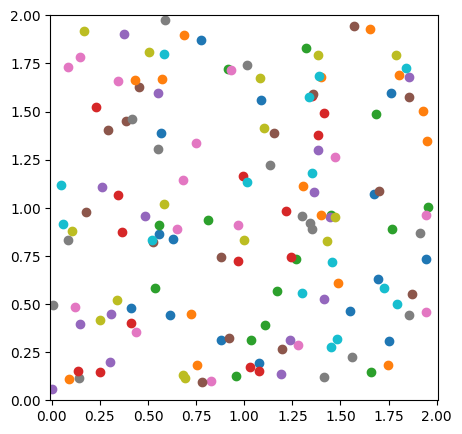

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))
def animate(i):
    plt.clf()
    population = results.history[i].pop.get("X")
    for m in population:
        print(m)
        inits = np.reshape(m,[5,2])
        plt.scatter(inits[:,0],inits[:,1])
    plt.axis('equal')
    plt.xlim([0,2])
    plt.ylim([0,2])


ani = animation.FuncAnimation(fig, animate, frames=50)

HTML(ani.to_html5_video())

You see a lot more diversity and nodes that are getting closer to each other (as we expect since we are minimizing material use). Both are expected and the larger diversity is a result of the algorithm exploring for both objectives rather than only one. To see how the population's performances are changing let's animate the population's performances for both objectives:

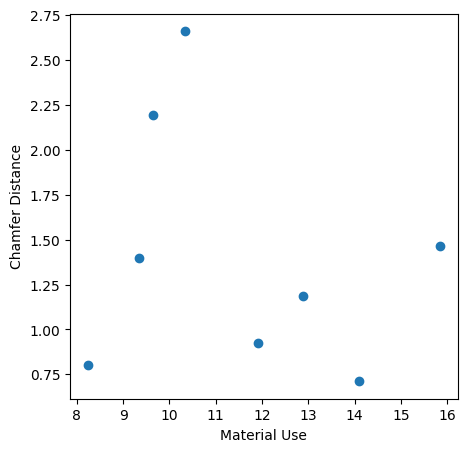

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))
plt.xlabel('Material Use')
plt.ylabel('Chamfer Distance')
def animate(i):
    plt.clf()
    plt.scatter(results.history[i].pop.get('F')[:,1],results.history[i].pop.get('F')[:,0])
    plt.xlabel('Material Use')
    plt.ylabel('Chamfer Distance')


ani = animation.FuncAnimation(fig, animate, frames=50)

HTML(ani.to_html5_video())

Pymoo automatically stores the ideal solutions it finds for both objectives (representing a non-dominated set) which we can plot to see how the Pareto front looks like:

Text(0, 0.5, 'Chamfer Distance')

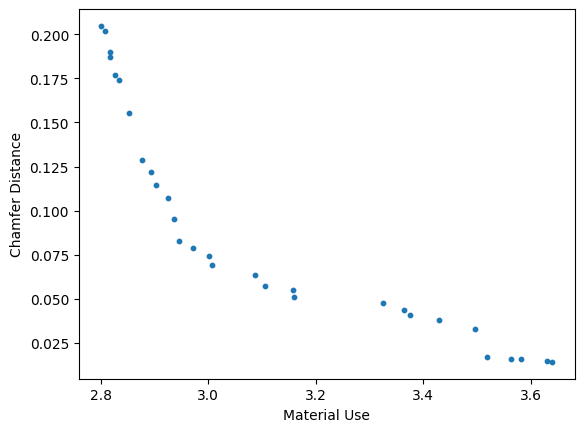

In [ ]:
plt.scatter(results.F[:,1],results.F[:,0],s=10)
plt.xlabel('Material Use')
plt.ylabel('Chamfer Distance')

As expected the higher the accuracy (lower chamfer distance) the more material is used. Usually, in these problems, the performance is evaluate based on a hypervolume. To calculate hypervolume here we set a reference point for the worst case (meaning the higher the hypervolume the better) at a point of chamfer distance 80 and material use equal to 3. Let's see what the hypervolume of this ideal set looks like:

Hyper Volume ~ 1.245604


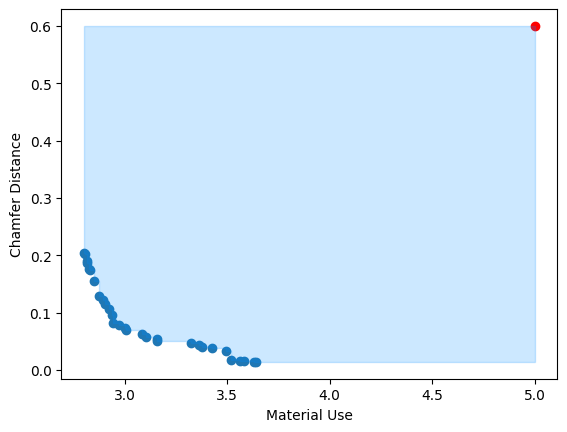

In [ ]:
from pymoo.indicators.hv import HV

F = results.F
filter = np.logical_and(F[:,0]<0.6, F[:,1]<5.0)
F = F[filter, :]

def plot_HV(F, ref): #This function just plots hypervolume - dont worry about it
    plt.scatter(F[:,1],F[:,0])
    plt.scatter(ref[0],ref[1],color="red")
    plt.xlabel('Material Use')
    plt.ylabel('Chamfer Distance')
    sorted_performance = F[np.argsort(F[:,1])]
    sorted_performance = np.concatenate([sorted_performance,[[0.6,5.0]]])
    inner_corners = np.stack([sorted_performance[:,0], np.roll(sorted_performance[:,1], -1)]).T
    final = np.empty((sorted_performance.shape[0]*2, 2))
    final[::2,:] = sorted_performance
    final[1::2,:] = inner_corners
    plt.fill(final[:,1],final[:,0],color="#008cff",alpha=0.2)


ref_point = np.array([0.6, 5.0])
ind = HV(ref_point)
HV = ind(F)

print('Hyper Volume ~ %f' %(HV))

plot_HV(F, [5.0,0.6])

Picking the best solution would be dependant on the problem and application but for now let's visualize the solution with the lowest chamfer distance (thinking of it as the single objective problem we had before). Now let's see the best solution(s) the algorithm came up with:

In [ ]:
if results.X.ndim >1:
    best_x0 = results.X[np.argmin(results.F[:,0])]
else:
    best_x0 = results.X

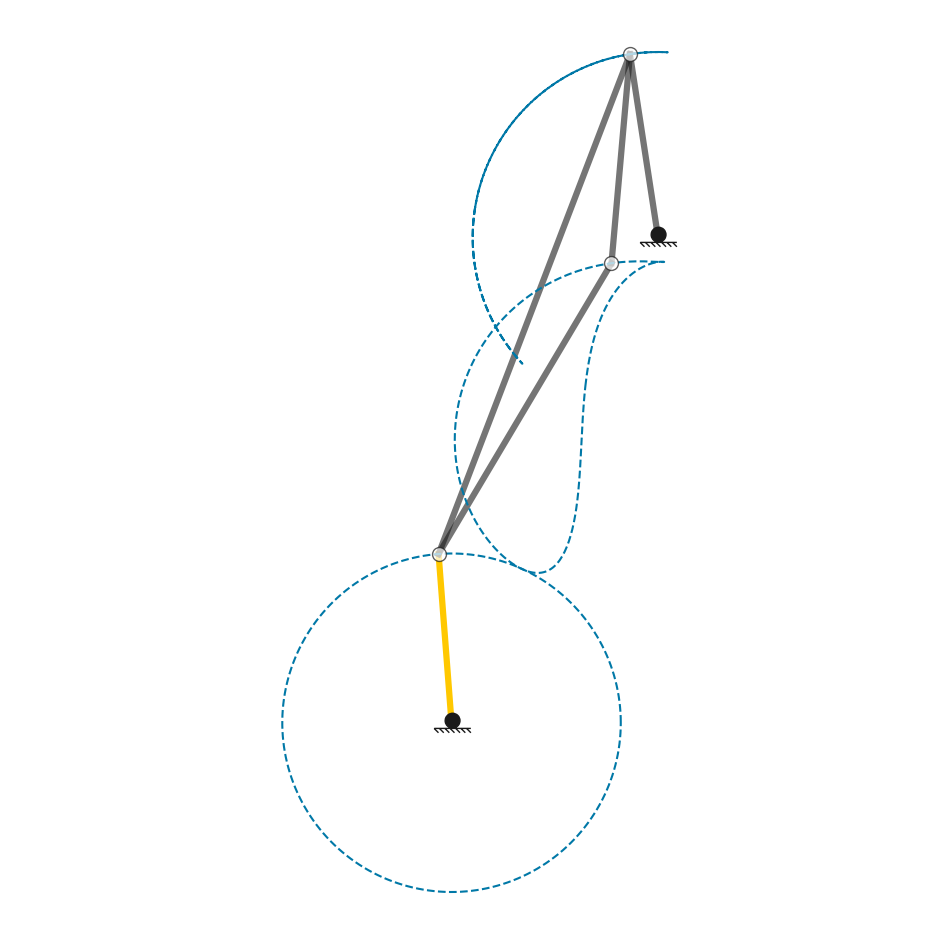

In [ ]:
# Step 1: Reshape
best_x0 = np.reshape(best_x0,[5,2])

# Step 2: Draw
draw_mechanism(C,best_x0,fixed_nodes,motor)

Now lets overlay the curves to see how close we got

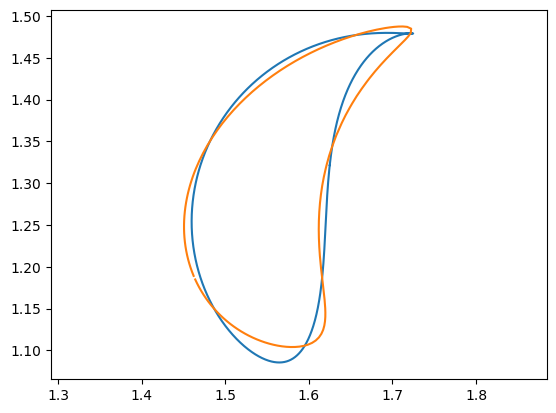

In [ ]:
_, _, _, _, _, aligned_curve = optimization_functions(C,best_x0,fixed_nodes,target_curve,motor)
comparecurves(best_x0, aligned_curve)

Now lets see the best solution for the second objective of material use:

In [ ]:
if results.X.ndim >1:
    best_x0 = results.X[np.argmin(results.F[:,1])]
    #best_x0 = results.X[np.argsort(results.F[:,1])[len(results.F[:,1])//2]]
else:
    best_x0 = results.X

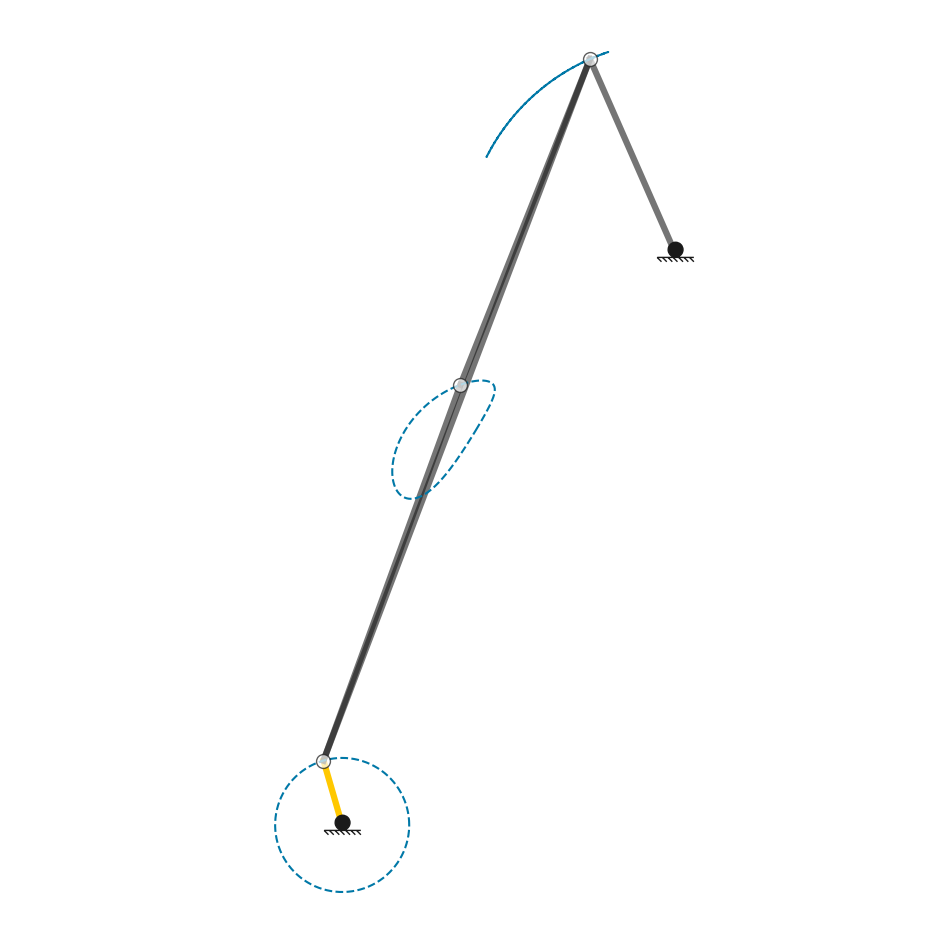

In [ ]:
# Step 1: Reshape
best_x0 = np.reshape(best_x0,[5,2])

# Step 2: Draw
draw_mechanism(C,best_x0,fixed_nodes,motor)

Now let's overlay the curves to see how close we got

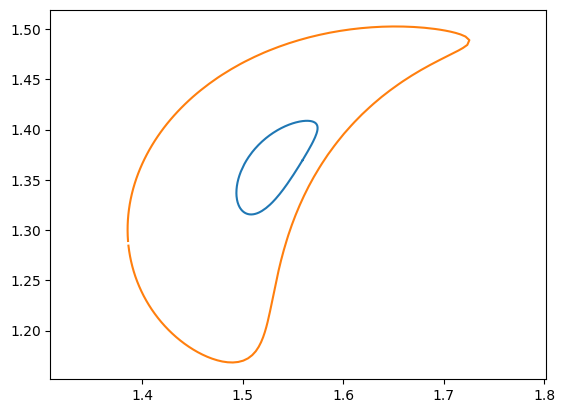

In [ ]:
_, _, _, _, _, aligned_curve = optimization_functions(C,best_x0,fixed_nodes,target_curve,motor)
comparecurves(best_x0, aligned_curve)

It can be seen this solution only focuses on material usage and the shape matching is largely ignored.

## Questions

In this demo, we only explored the question of node positioning -- we considered a single linkage configuration and did not consider larger linkages or other configurations.

- [x] How do you expect these methods to behave as mechanisms get larger?
- [x] Test your hypothesis. We are providing a function to generate random mechanisms of a particular size.
- [x] Rerun some of the optimizers in this notebook and see how they do!
- [x] Does gradient-based optimization find a strong solution in complex problems?
- [ ] In addition, what do you think are some strategies for using gradient-based optimization in multi-objective problems?

### Hypotheses
1. The single-objective Gradient Descent optimization will not converge to as good of a solution as the system becomes larger/more complex.
2. The single-objective NSGA-II will converge to a better solution because it should not get stuck in a local minima (due to the more stochastic nature of Genetic Algorithms)
3. The single-objective NSGA-II will take longer to run than the Gradient Descent because it generates and evaluates many more mechanisms (for every iteration).

### Approach

To test my hypotheses, I ran the following code ~5 times. Each run:
1. Generated a set of random mechanisms with 5, 7, 9, and 11, nodes
2. Generated a solution for each mechanism using the Scipy Gradient Descent algorithm
3. Generate a solution for each mechanism using NSGA-II

All this was to gain a qualitative comparison of the performance of the Gradient Descent algorithm (as implemented in Scipy).

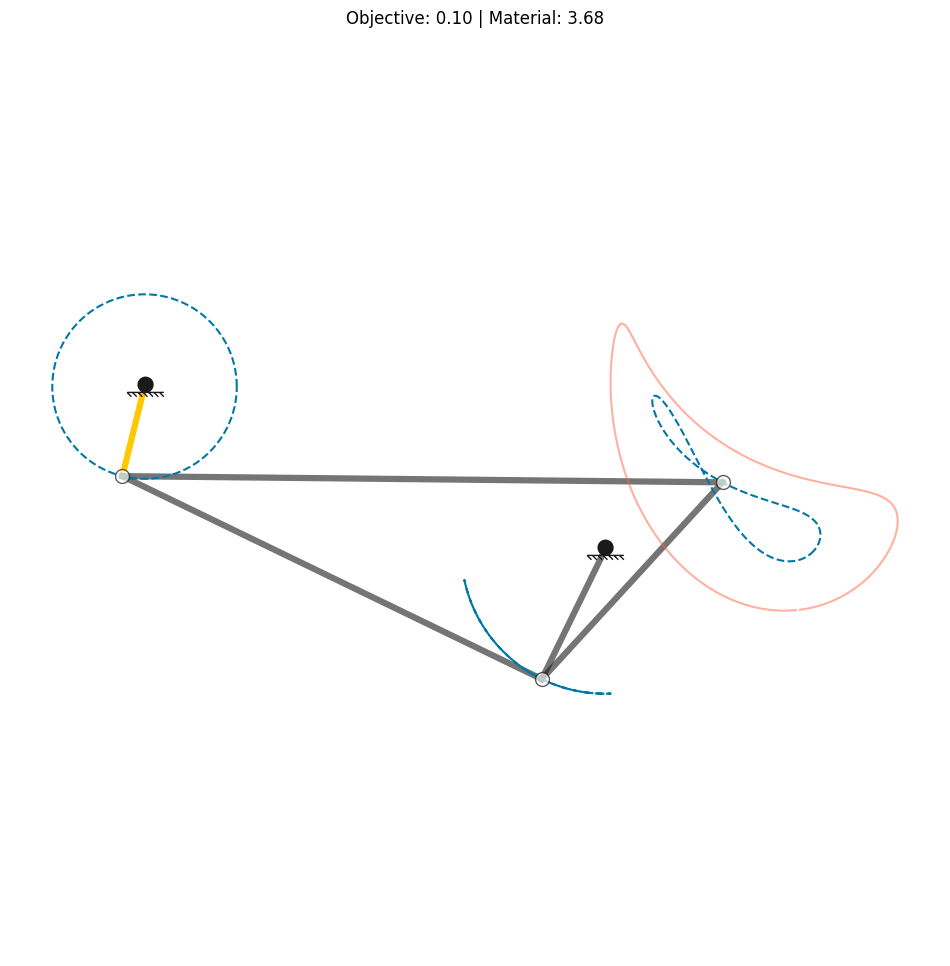

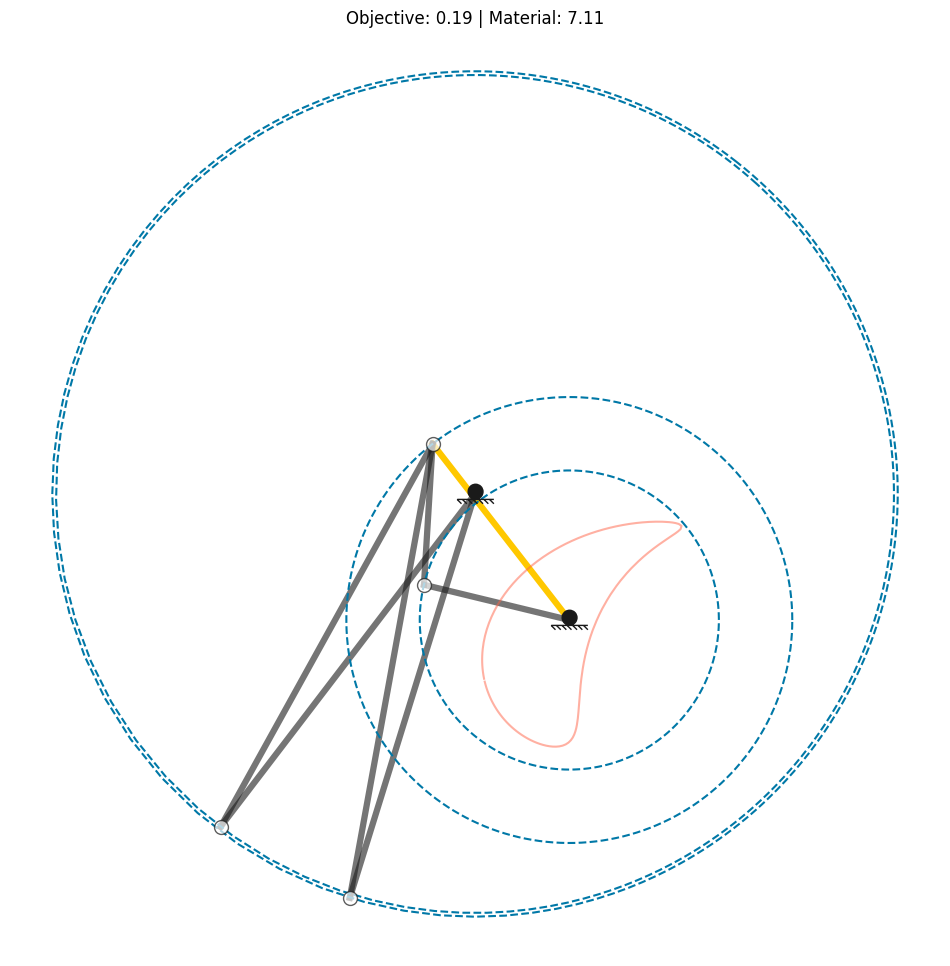

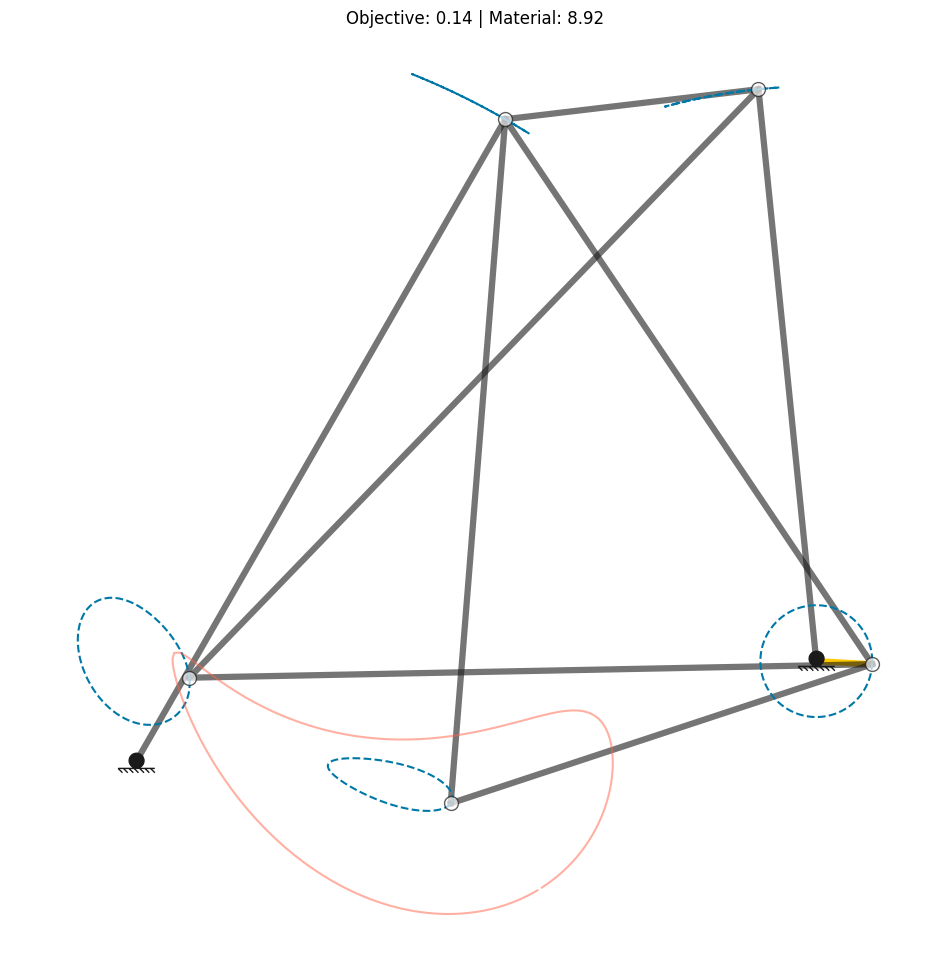

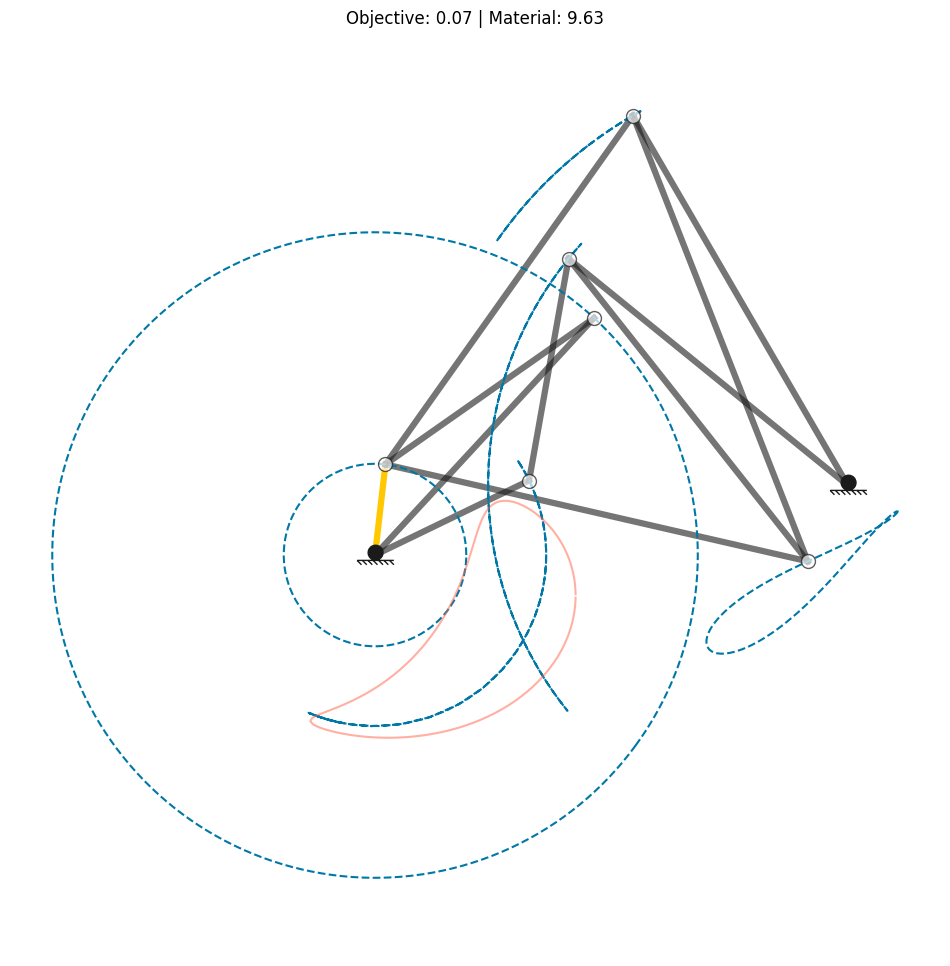

In [ ]:
# generate a few mechanisms, store them in a data structure
mechanisms=[]
for n in [5,6,7,8]:

    C,x0,fixed_nodes,motor = random_generator_ns(n=n) #Generates a random mechanism of size n
    v, obj_fn, obj_fn_grad, mat_fn, mat_fn_grad, aligned_curve = optimization_functions(C,x0,fixed_nodes,target_curve, motor)
    obj, obj_grad = obj_fn(x0), obj_fn_grad(x0)
    mat, mat_grad = mat_fn(x0), mat_fn_grad(x0)

    mechanisms.append({'n':n,
                       'C':C,
                       'x0':x0,
                       'fixed_nodes':fixed_nodes,
                       'motor':motor,
                       'aligned_curve':aligned_curve,
                       'v':v,
                       'obj_fn':obj_fn,
                       'obj':obj,
                       'obj_fn_grad':obj_fn_grad,
                       'mat_fn':mat_fn,
                       'mat':mat,
                       'mat_fn_grad':mat_fn_grad})

    draw_mechanism(C, x0, fixed_nodes, motor)
    plt.plot(aligned_curve[:,0], aligned_curve[:,1], 'tomato', alpha=0.5)
    plt.title(f'Objective: {obj:.2f} | Material: {mat:.2f}');


#### Test: Scipy (Gradient Descent) Optimization

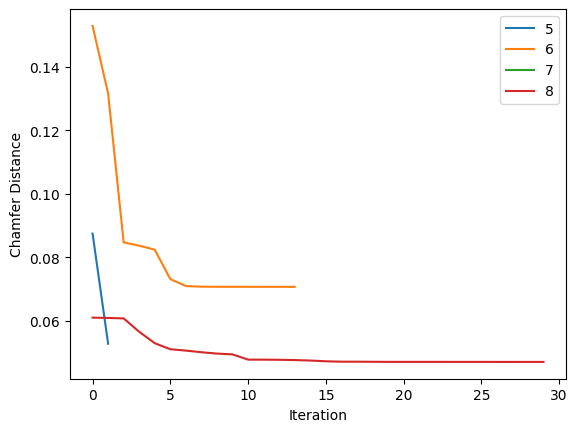

In [ ]:
from scipy.optimize import minimize

for m in mechanisms:
    m.update({'x_history':[], 'CD_history':[]})
    def callback(x):
        m['x_history'].append(x)
        m['CD_history'].append(m['obj_fn'](x))
    m.update({'res': minimize(m['obj_fn'],m['x0'].reshape(-1),jac=m['obj_fn_grad'],method='BFGS', callback = callback)})
    m.update({'obj_gd': m['obj_fn'](m['res'].x)})
    plot_CD_convergence(m['CD_history'], n=m['n'])

In [ ]:
from MOOCP.linkage_utils import preprocess_curves
def comparecurves_GD(m):
    sol = solve_mechanism(m['C'],m['res'].x.reshape(m['x0'].shape),m['fixed_nodes'],m['motor'])[1][0,-1,:]
    plt.plot(sol[:,0],sol[:,1],label=f'%u nodes' % (m['n'],))
    plt.plot(m['aligned_curve'][:,0],m['aligned_curve'][:,1],label="aligned curve")
    plt.legend()
    plt.title(f'GD\nObjective: %.2f | Material: %.2f' % (m['obj'],m['mat']));
    plt.axis('equal')


#### Test: NSGA-II

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

for m in mechanisms:
    # Setup an instance of our problem
    problem = mechanism_optimization(m['C'],m['fixed_nodes'],m['motor'],target_curve)

    # Setup the algorithm
    algorithm = NSGA2(pop_size=30,
                    sampling=FloatRandomSampling(),
                    crossover=SBX(prob=1.0, eta=3.0),
                    mutation=PolynomialMutation(eta=3.0, prob=0.2),
                    eliminate_duplicates=True)

    results = minimize(problem,
                   algorithm,
                   ('n_gen', 50),
                   verbose=False,
                   save_history=False,
                   seed=3,
                   display=best())

    m.update({'nsga2res': results})

    if results.X.ndim >1:
        m.update({'best_x0':results.X[0]})
    else:
        m.update({'best_x0':results.X})

    m['best_x0'] = np.reshape(m['best_x0'],[m['n'],2])

    m['obj_ngsa'] = m['obj_fn'](m['best_x0'])
    m['mat_ngsa'] = m['mat_fn'](m['best_x0'])

In [ ]:
def comparecurves_NSGAII(x, aligned_curve, m):
    sol = solve_mechanism(m['C'],x.reshape(m['x0'].shape),m['fixed_nodes'],m['motor'])[1][0,-1,:]
    plt.plot(sol[:,0],sol[:,1],label=f'%u nodes' % (m['n'],))
    plt.plot(aligned_curve[:,0],aligned_curve[:,1],label="aligned curve")
    plt.legend()
    plt.title(f'NSGA-II\nObjective: %.2f | Material: %.2f' % (m['obj_ngsa'],m['mat']));
    plt.axis('equal')

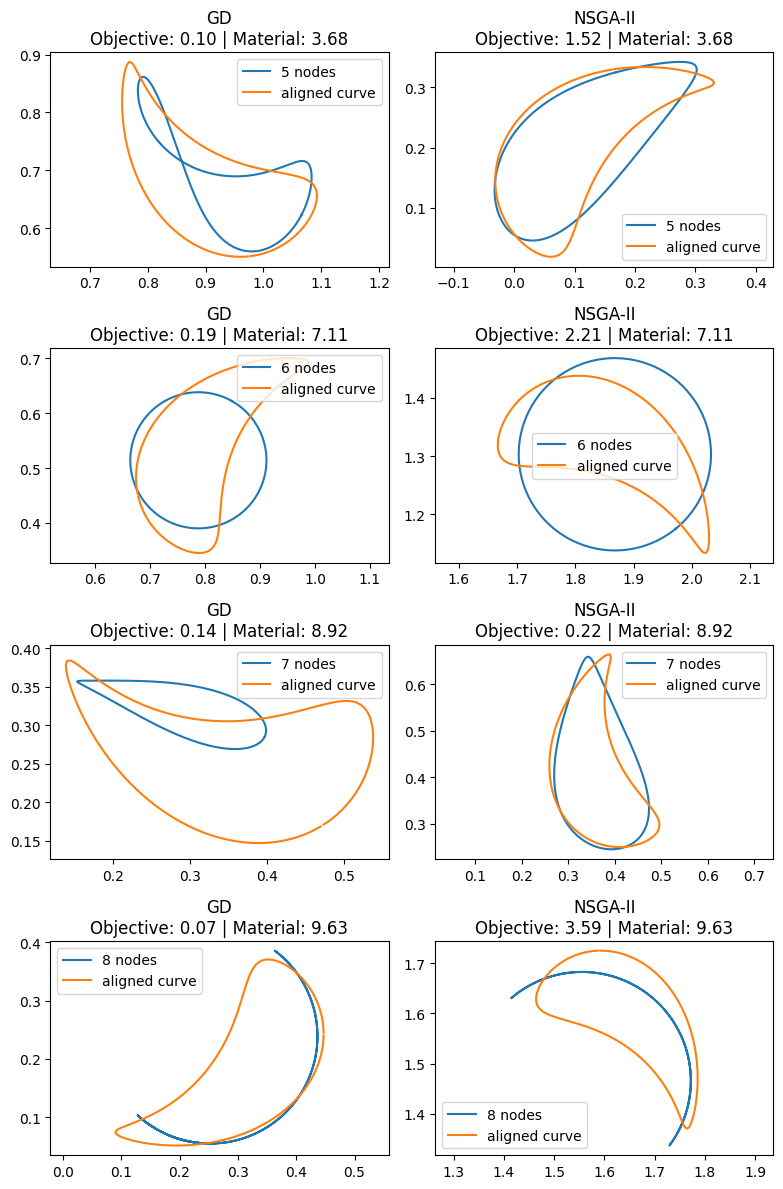

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8,12))

i=1
for m in mechanisms:
    plt.subplot(4, 2, i)
    comparecurves_GD(m)
    plt.gca().set_aspect('equal')
    i += 1

    plt.subplot(4, 2, i)
    _, _, _, _, _, aligned_curve = optimization_functions(m['C'],m['best_x0'],m['fixed_nodes'],target_curve,m['motor'])
    comparecurves_NSGAII(m['best_x0'], aligned_curve, m)
    plt.gca().set_aspect('equal')
    i += 1

plt.tight_layout()



In [ ]:
import pandas as pd

df = pd.DataFrame(mechanisms)
#df
df[['n', 'obj', 'obj_gd', 'obj_ngsa']]

,n,obj,obj_gd,obj_ngsa
0,5,0.10187982,0.05270996,1.5191678
1,6,0.19107959,0.07064311,2.2131772
2,7,0.13886642,0.098802775,0.21637446
3,8,0.07438549,0.046980314,3.5920014


### Conclusion

After running a few iterations of the above code and analyzing the results, I wasn't confident in my results, so I posted [this Slack thread](https://mit-ai-for-design24.slack.com/archives/C07LKBSGL3V/p1727140180134509).

Following the discussion there, I came to the following conclusions.

#### Gradient Descent (GD) vs Genetic Algorithm (GA)

These types of mechanisms have configurations that lock and won't generate a valid result - this seems to increase with the number of nodes. When the GD algorithm hits one of these invalid configurations, it seems to stop and simply return the previous solution, illustrated in [the convergence graph](https://colab.research.google.com/drive/1cLU7aaFRsZSaGBOaqTK_v42tk1mLla2D#scrollTo=6nXCfjCyQr1G&line=1&uniqifier=1) where some mechanisms converge cleanly, others don't ultimately converge, and the rest don't even start to converge).

With randomly generated mechanism starting configurations, GD indeed seems to *sometimes* get stuck in local minima. Other times, however, it appeared that the local minima it reached was indeed the *global* minima. My hypotheses assumed that GD's found minima would not likely be the global minima; my results suggest otherwise.

While GA was more likely to overcome the locked mechanism (eventually converging to *something*), it consistently generated a less optimal solution than GD. Theoretically, if the GA could run forever, it could locate and converge on the global minimum, but my experiments were resource- and time-limited, so this never came to be.

#### Improving Gradient Descent for Complex Problems

As is, Gradient Descent does not always produce a strong solution due to locking and the tendency to get stuck in local minima. We can perhaps overcome these two limiting factors by adding some stochasticity prior to running GD. For example, we could complete a hybrid GA/GD algorithm: roughly locate the global minimum using GA and then converge more precisely using GD. Another method could be to randomize multiple starting node positions, run GD on each, and then take the minimum of all those alternatives.